# Conformer model

This notebook runs through the designing and hyperparameter selection process for the Transformer model.

To do this we follow the steps:

+ Import the data
+ Design a preliminary model and test on the six different pre-processed data types
    + Proceed with the best one
+ Tune the hyperparameters
    + Test more transformer blocks.

In [7]:
#set up the workspace, environment and load libraries
#----------------------------------------------------
#Set sytem version
import sys
assert sys.version_info >= (3, 7)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#import sklearn
import sklearn
assert sklearn.__version__>="0.20"

#import tensorflow
from packaging import version
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")

#import libraries
import pandas as pd
import numpy as np
import pandas as pd
import G9_functions

#Figure setup
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Load the Datafiles

In [8]:
#load the three different frame types
padded_trunc_mfcc_50_path="Data/padded_truncated_mfcc_50ms.csv" #soundfiles split to 50ms
padded_trunc_mfcc_100_path="Data/padded_truncated_mfcc_100ms.csv" #soundfiles split to 100ms frames
padded_trunc_mfcc_500_path="Data/padded_truncated_mfcc_500ms.csv" #soundfiles split to 500ms frames

#Read into dataframes
padded_trunc_mfcc_50 = pd.read_csv(padded_trunc_mfcc_50_path)
padded_trunc_mfcc_100 =  pd.read_csv(padded_trunc_mfcc_100_path)
padded_trunc_mfcc_500 =  pd.read_csv(padded_trunc_mfcc_500_path)

#collect truncation lengths
truncation_length_dic={ "padded_trunc_mfcc_50":padded_trunc_mfcc_50.iloc[0, -1],
                       "padded_trunc_mfcc_100":padded_trunc_mfcc_100.iloc[0, -1],
                       "padded_trunc_mfcc_500":padded_trunc_mfcc_500.iloc[0, -1]
                      }

In [9]:
# Define the mapping dictionary
label_mapping = {'S1': 1,'S2': 2,'S3': 3, 'N': 0}

# Replace values in the 'label' column using the mapping dictionary
padded_trunc_mfcc_50['label'] = padded_trunc_mfcc_50['label'].replace(label_mapping)
padded_trunc_mfcc_100['label'] = padded_trunc_mfcc_100['label'].replace(label_mapping)
padded_trunc_mfcc_500['label'] = padded_trunc_mfcc_500['label'].replace(label_mapping)

### Prepare Data for transformer

In [10]:
def prepare_X_y_sequences_mfcc_data(df,num_mfccs,truncated_length):
    mfcc_columns = [f'mfcc_{i}' for i in range(1, num_mfccs+1)] #list of the MFCC values
    X = np.array([df[mfcc_column].apply(eval).tolist() for mfcc_column in mfcc_columns]) #merge the MFCC for each instance to a single list e.g. [mfcc1,mfcc2,...,mfcc13]time,
    X = X.transpose(1, 0, 2)  # Transpose to (13, number_of_samples, reference_length)
    X = X.reshape(-1, truncated_length, 13)
    y = df['label']
    return X, y

In [11]:
X_50,y_50 = prepare_X_y_sequences_mfcc_data(padded_trunc_mfcc_50,13,truncation_length_dic.get("padded_trunc_mfcc_50"))

X_100,y_100 = prepare_X_y_sequences_mfcc_data(padded_trunc_mfcc_100,13,truncation_length_dic.get("padded_trunc_mfcc_100"))

X_500,y_500 = prepare_X_y_sequences_mfcc_data(padded_trunc_mfcc_500,13,truncation_length_dic.get("padded_trunc_mfcc_500"))

### Test Train Split

In this section we split the data into a testing and training data. The function `train_test_val_datasets_mfcc_sequences` is designed to standardize the data based on the training split if the user wishes and also perform stratified sampling. The train, validation and test split is 65%, 15% and 20% respectively.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Function to create test, train, val datasets
def train_test_val_datasets_mfcc_sequences(X, y, test_size=0.2, val_size=0.15, stratify=True, random_state=False, scale=False, num_mfccs=False):
    
    val_size = 0.15/ (1-test_size) #
    
    if stratify is True:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y,shuffle=True,random_state=random_state)
        if scale is True:
            
            #Obtain shapes
            X_train_shape=X_train.shape
            X_test_shape=X_test.shape
            
            #scale the MFCCs on the training set
            scaler = StandardScaler()
            scaler.fit(X_train.reshape(-1,num_mfccs))
            X_train = scaler.transform(X_train.reshape(-1,num_mfccs))
            X_test=scaler.transform(X_test.reshape(-1,num_mfccs))
            
            #reshape back into sequences of MFCCS
            X_train = X_train.reshape(X_train_shape)
            X_test = X_test.reshape(X_test_shape)
            
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train,shuffle=True, random_state=random_state)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,shuffle=True,random_state=random_state)
        if scale is True:
            
            #Obtain shapes
            X_train_shape=X_train.shape
            X_test_shape=X_train.shape
            
            #scale the MFCCs on the training set
            scaler = StandardScaler()
            scaler.fit(X_train.reshape(-1,num_mfccs))
            X_train = scaler.transform(X_train.reshape(-1,num_mfccs))
            X_test=scaler.transform(X_test.reshape(-1,num_mfccs))
            
            #reshape back into sequences of MFCCS
            X_train = X_train.reshape(X_train_shape)
            X_test = X_test.reshape(X_test_shape)
            
        
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size,shuffle=True, random_state=random_state)
    return X_train, y_train, X_val, y_val, X_test, y_test
    

In [13]:
X_train_50, y_train_50, X_val_50, y_val_50, X_test_50, y_test_50 = train_test_val_datasets_mfcc_sequences(X=X_50, y=y_50, test_size=0.2, val_size=0.15,stratify=True,random_state=False,scale=True, num_mfccs=13)

X_train_100, y_train_100, X_val_100, y_val_100, X_test_100, y_test_100 =train_test_val_datasets_mfcc_sequences(X=X_100,y=y_100,test_size=0.2,val_size=0.15,stratify=True,random_state=False, scale=True,num_mfccs=13)

X_train_500, y_train_500, X_val_500, y_val_500, X_test_500, y_test_500 = train_test_val_datasets_mfcc_sequences(X=X_500,y=y_500,test_size=0.2,val_size=0.15,stratify=True,random_state=False, scale=True,num_mfccs=13)

In [14]:
# Create new binary labels objects by copying the original labels
y_train_50_B = np.copy(y_train_50)
y_val_50_B = np.copy(y_val_50)
y_test_50_B = np.copy(y_test_50)
y_train_100_B = np.copy(y_train_100)
y_val_100_B = np.copy(y_val_100)
y_test_100_B = np.copy(y_test_100)
y_train_500_B = np.copy(y_train_500)
y_val_500_B = np.copy(y_val_500)
y_test_500_B = np.copy(y_test_500)

# Convert classes to binary (1 for positive class, 0 for others)
y_train_50_B[y_train_50_B > 0] = 1
y_val_50_B[y_val_50_B > 0] = 1
y_test_50_B[y_test_50_B > 0] = 1
y_train_100_B[y_train_100_B > 0] = 1
y_val_100_B[y_val_100_B > 0] = 1
y_test_100_B[y_test_100_B > 0] = 1
y_train_500_B[y_train_500_B > 0] = 1
y_val_500_B[y_val_500_B > 0] = 1
y_test_500_B[y_test_500_B > 0] = 1

# Conformer model

The conformer model bears a resemblance to the transformer model, albeit with certain modifications. Notably, its self-attention block incorporates two 1D convolutional layers flanking the self-attention layer, a design primarily inspired by Gulati et al. (2020). However, a key divergence lies in replacing the linear feedforward block with a 1D convolutional block, and the final linear feedforward block is removed. These adjustments were made through iterative experimentation, aiming to mitigate overfitting.

#### Part 1: Define a simple Conformer architecture

In this code block a class is created to create the positonal encodings layer using Sine/Cosine positional encodings.

In [15]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super(PositionalEncoding, self).__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length), 2 * np.arange(embed_size // 2))
        pos_encodings = np.empty((1, max_length, embed_size))
        pos_encodings[0, :, ::2] = np.sin(p / 10000 ** (i / embed_size)).T
        pos_encodings[0, :, 1::2] = np.cos(p / 10000 ** (i / embed_size)).T
        
        # Masked positions set to zeros
        self.pos_encodings = tf.constant(pos_encodings.astype(self.dtype))
        self.supports_masking = True
        
    def call(self, inputs, mask=None):
        batch_max_length = tf.shape(inputs)[1]
        pos_encodings = self.pos_encodings[:, :batch_max_length, :]
        outputs = inputs + pos_encodings
        
        # Apply mask if provided
        if mask is not None:
            outputs *= tf.expand_dims(1 - mask, axis=-1)
        
        return outputs
        

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import MultiHeadAttention as ConformerMultiHeadAttention

# Custom GLU activation function
def glu(x):
    # Split the input tensor into two parts along the last axis
    x1, x2 = tf.split(x, 2, axis=-1)
    
    # Apply the sigmoid activation function to the second half
    x2 = tf.sigmoid(x2)
    
    # Element-wise multiplication of x1 and x2
    return x1 * x2

#create a custome conformer block

class Conformer(layers.Layer):
    def __init__(self, num_heads=8,key_dim=12,value_dim=12,dropout=0.1,filters=24,**kwargs):
        
        super(Conformer, self).__init__(**kwargs)
        
      
    
        #Convolutional module as shown in l Gulati et al. (2020)
        self.convolution_module = keras.Sequential([
            
            layers.LayerNormalization(epsilon=1e-6),
            layers.Conv1D(filters, kernel_size=1), #pointwise convolutional layer
            layers.Activation(glu),
            
            layers.DepthwiseConv1D(kernel_size=3, padding="same",use_bias=False),
            layers.BatchNormalization(),
            layers.Activation("swish"),
            
            layers.Conv1D(12 , kernel_size=1),  #pointwise convolutional layer
            layers.Activation('relu'),
            layers.Dropout(dropout)
            
            ])
        
        #Multi-Head attention component
        self.multi_head_attention_module = ConformerMultiHeadAttention(
            num_heads=num_heads, key_dim=key_dim, value_dim=value_dim, dropout=0.1)
    
    
        
        # Convolutional Feedforward block at the end
        self.ff_module_end = keras.Sequential([
            layers.Conv1D(filters , kernel_size=1),  #pointwise convolutional layer
            layers.Activation('relu'),
            layers.Dense(12,kernel_initializer='he_normal',use_bias=False),
            layers.Activation('relu'),
            layers.BatchNormalization()
        ])
            
        
        # Addition layer for residual connection
        self.addition = layers.Add()
        
        # Layer Normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)

        
    
    def call(self, inputs, training=False):
        
        #feedforward block START
        #ffn_start_output = self.ff_module_start(inputs)
            
        #Convolutional block
        ffn_conv_output = self.convolution_module(inputs)
        
        #Addition  
        ffn_conv_output  = self.addition([inputs, ffn_conv_output])
        
        
        #Multi-HEad attension block
        attention_output = self.multi_head_attention_module(ffn_conv_output , ffn_conv_output , ffn_conv_output , training=training)
        
        #Addition  
        attention_output = self.addition([ffn_conv_output, attention_output])
        

        #feedforwardblock END
        ffn_end_output = self.ff_module_end(attention_output)
        
        #Addition  
        ffn_end_output = self.addition([attention_output, ffn_end_output])
            
        #layer normalisation layer
        ffn_end_output = self.layernorm1( ffn_end_output, training=training)
        
        return ffn_end_output
    

# Define the Transformer model for the mfcc_sequences
def create_conformer_model_mfcc_sequences(max_seq_length, num_classes, num_mfcc_features):
    
    inputs = keras.Input(shape=(max_seq_length, num_mfcc_features))  # Input shape for MFCCs
    
    #postional encodings layer
    positional_embed_layer = PositionalEncoding(max_seq_length,num_mfcc_features)(inputs)
    
    
    # Conformer block
    conformer_output = Conformer()(positional_embed_layer)

    
    # Global Average Pooling to reduce sequence length
    avg_pooling = layers.GlobalAveragePooling1D()(conformer_output)
    
    # Output layer for classification
    if num_classes == 2:
        outputs = layers.Dense(1, activation="sigmoid")(avg_pooling)
    
    else:
        outputs = layers.Dense(num_classes, activation="softmax")(avg_pooling)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

#### Part 2: Compare the time splits

In [21]:
#Multiclass Models
conformer_model_50_MC = create_conformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_50"), 4,12)
conformer_model_100_MC = create_conformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_100"), 4,12)
conformer_model_500_MC = create_conformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_500"), 4,12)

#Binary Models
conformer_model_50_B = create_conformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_50"), 2,12)
conformer_model_100_B = create_conformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_100"), 2,12)
conformer_model_500_B = create_conformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_500"), 2,12)

In [22]:
# Compile the models
conformer_model_50_MC.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
conformer_model_100_MC.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
conformer_model_500_MC.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
conformer_model_50_B.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
conformer_model_100_B.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
conformer_model_500_B.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [23]:
class PrintEpochLossCallback(tf.keras.callbacks.Callback):
    def __init__(self, n=5):
        super().__init__()
        self.n = n
        self.best_val_loss = float('inf')  # Initialize best_val_loss with positive infinity
        self.best_epoch = 0


    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.n == 0:
            
 
            print("Epoch", epoch, "loss:", round(logs["loss"], 5), "val_loss:", round(logs["val_loss"], 5),
                  "acc:", round(logs["accuracy"], 5), "val_acc:", round(logs["val_accuracy"], 5))
    
        # Check if the current epoch has the best validation loss
        if logs["val_loss"] < self.best_val_loss:
            self.best_val_loss = logs["val_loss"]
            self.best_epoch = epoch
    
    
    def on_train_end(self, logs=None):
        print("Model finished training")
        print("Best epoch:", self.best_epoch, "with val_loss:", round(self.best_val_loss, 5))

# Assuming X_val and y_val are your validation data
custom_callback = PrintEpochLossCallback(n=10)

In [24]:
# Define the number of epochs and batch size
epochs = 10
batch_size = 32

# Fit/Train the MC models
history_50_MC = conformer_model_50_MC.fit(X_train_50[:,:,:-1], y_train_50,epochs=epochs,batch_size=batch_size,
                                      validation_data=(X_val_50[:,:,:-1], y_val_50),verbose=0,callbacks=[custom_callback])

history_100_MC = conformer_model_100_MC.fit(X_train_100[:,:,:-1], y_train_100,epochs=epochs,batch_size=batch_size,
                                        validation_data=(X_val_100[:,:,:-1], y_val_100),verbose=0,callbacks=[custom_callback])

history_500_MC = conformer_model_500_MC.fit(X_train_500[:,:,:-1], y_train_500,epochs=epochs,batch_size=batch_size,
                                        validation_data=(X_val_500[:,:,:-1], y_val_500),verbose=0,callbacks=[custom_callback])


# Fit/Train the Binary models
history_50_B = conformer_model_50_B.fit(X_train_50[:,:,:-1], y_train_50_B,epochs=epochs,batch_size=batch_size,
                                      validation_data=(X_val_50[:,:,:-1], y_val_50_B),verbose=0,callbacks=[custom_callback])

history_100_B = conformer_model_100_B.fit(X_train_100[:,:,:-1], y_train_100_B,epochs=epochs,batch_size=batch_size,
                                        validation_data=(X_val_100[:,:,:-1], y_val_100_B),verbose=0,callbacks=[custom_callback])

history_500_B = conformer_model_500_B.fit(X_train_500[:,:,:-1], y_train_500_B,epochs=epochs,batch_size=batch_size,
                                        validation_data=(X_val_500[:,:,:-1], y_val_500_B),verbose=0,callbacks=[custom_callback])

Epoch 0 loss: 0.38205 val_loss: 0.19916 acc: 0.85129 val_acc: 0.92724
Model finished training
Best epoch: 5 with val_loss: 0.13544
Epoch 0 loss: 0.35105 val_loss: 0.26323 acc: 0.85585 val_acc: 0.88574
Model finished training
Best epoch: 5 with val_loss: 0.13544
Epoch 0 loss: 0.2671 val_loss: 0.16787 acc: 0.90058 val_acc: 0.93766
Model finished training
Best epoch: 7 with val_loss: 0.13222
Epoch 0 loss: 0.28604 val_loss: 0.37684 acc: 0.8718 val_acc: 0.85709
Model finished training
Best epoch: 8 with val_loss: 0.10457
Epoch 0 loss: 0.23668 val_loss: 0.1642 acc: 0.89372 val_acc: 0.93141
Model finished training
Best epoch: 8 with val_loss: 0.10457
Epoch 0 loss: 0.18862 val_loss: 0.1231 acc: 0.92735 val_acc: 0.95781
Model finished training
Best epoch: 5 with val_loss: 0.10174


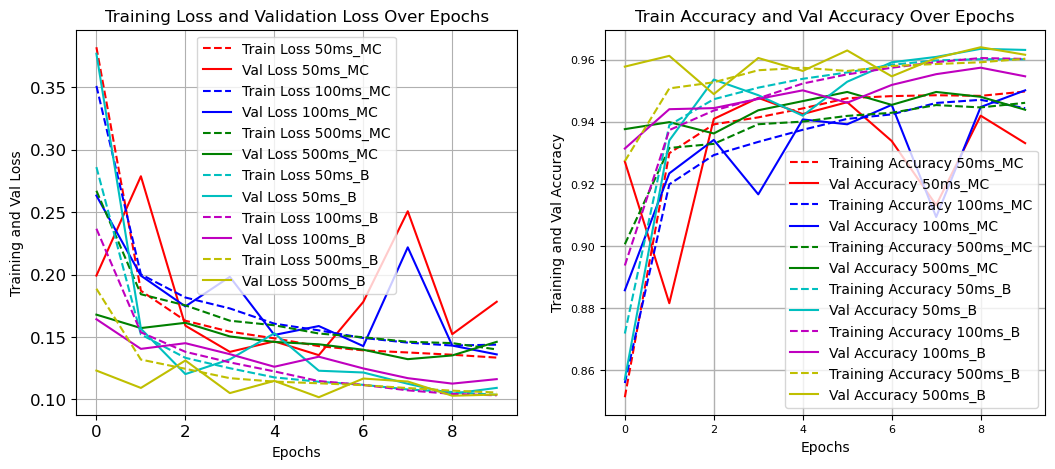

<Figure size 640x480 with 0 Axes>

In [25]:
history_dic={'50ms_MC':history_50_MC,
             '100ms_MC':history_100_MC,
             '500ms_MC':history_500_MC,
             '50ms_B':history_50_B,
             '100ms_B':history_100_B,
             '500ms_B':history_500_B}
G9_functions.plot_learning_curves(history_dic)
plt.savefig("Learning_curves_Conformer_Model.png")

The learning curves show that the models using the 500ms are the best with the lowest and most stable validation and training loss.

We will continue with the 500ms dataset for training the hyperparameters of the transformer model.

### Accuracy and F1-Score comparison

In [26]:
#Predict the results of the multi-class models
#50ms model
y_proba_test_50_MC = conformer_model_50_MC.predict(X_test_50[:,:,:-1])
y_pred_test_50_MC =y_proba_test_50_MC.argmax(axis=-1)
#100ms model
y_proba_test_100_MC = conformer_model_100_MC.predict(X_test_100[:,:,:-1])
y_pred_test_100_MC =y_proba_test_100_MC.argmax(axis=-1)
#500ms model
y_proba_test_500_MC = conformer_model_500_MC.predict(X_test_500[:,:,:-1])
y_pred_test_500_MC =y_proba_test_500_MC.argmax(axis=-1)


#Predict the results for the binary models
threshold=0.5
#50ms model
y_proba_test_50_B = conformer_model_50_B.predict(X_test_50[:,:,:-1])
y_pred_test_50_B =(y_proba_test_50_B >= threshold).astype(int)
#100ms model
y_proba_test_100_B = conformer_model_100_B.predict(X_test_100[:,:,:-1])
y_pred_test_100_B =(y_proba_test_100_B >= threshold).astype(int)
#500ms model
y_proba_test_500_B = conformer_model_500_B.predict(X_test_500[:,:,:-1])
y_pred_test_500_B =(y_proba_test_500_B >= threshold).astype(int)

240/240 [==============================] - 1s 3ms/step


In [27]:
from sklearn.metrics import accuracy_score, f1_score


# Calculate accuracy and F1 scores for multi-class models
accuracy_50_MC = accuracy_score(y_test_50, y_pred_test_50_MC)
f1_50_MC = f1_score(y_test_50, y_pred_test_50_MC, average='weighted')

accuracy_100_MC = accuracy_score(y_test_100, y_pred_test_100_MC)
f1_100_MC = f1_score(y_test_100, y_pred_test_100_MC, average='weighted')

accuracy_500_MC = accuracy_score(y_test_500, y_pred_test_500_MC)
f1_500_MC = f1_score(y_test_500, y_pred_test_500_MC, average='weighted')

# Calculate accuracy and F1 scores for binary models
accuracy_50_B = accuracy_score(y_test_50_B, y_pred_test_50_B)
f1_50_B = f1_score(y_test_50_B, y_pred_test_50_B)

accuracy_100_B = accuracy_score(y_test_100_B, y_pred_test_100_B)
f1_100_B = f1_score(y_test_100_B, y_pred_test_100_B)

accuracy_500_B = accuracy_score(y_test_500_B, y_pred_test_500_B)
f1_500_B = f1_score(y_test_500_B, y_pred_test_500_B)

# Create a table to display the results
data = {
    "Model": ["50ms Multi-Class", "100ms Multi-Class", "500ms Multi-Class",
              "50ms Binary", "100ms Binary", "500ms Binary"],
    "Accuracy": [accuracy_50_MC, accuracy_100_MC, accuracy_500_MC,
                 accuracy_50_B, accuracy_100_B, accuracy_500_B],
    "F1 Score": [f1_50_MC, f1_100_MC, f1_500_MC,
                 f1_50_B, f1_100_B, f1_500_B]
}

results_df = pd.DataFrame(data)
print(results_df)

               Model  Accuracy  F1 Score
0   50ms Multi-Class  0.939445  0.941834
1  100ms Multi-Class  0.950254  0.949621
2  500ms Multi-Class  0.940096  0.941067
3        50ms Binary  0.964058  0.965901
4       100ms Binary  0.960802  0.962743
5       500ms Binary  0.957937  0.959970


In [28]:
history_data = []
for model, history in history_dic.items():
    for epoch in range(len(history.history['loss'])):
        history_data.append({
            'Model': model,
            'Epochs': epoch + 1,
            'Loss': history.history['loss'][epoch],
            'Accuracy': history.history['accuracy'][epoch],
            'Val_Loss': history.history['val_loss'][epoch],
            'Val_Accuracy': history.history['val_accuracy'][epoch]
        })
        
history_df = pd.DataFrame(history_data)

csv_file_path = 'Conformer_history_data.csv'

# Export the DataFrame to a CSV file
history_df.to_csv(csv_file_path, index=False)

#Export Transformer results to dictionary
results_df.to_csv('Conformer_Acc_F1.csv',index=True)

## Hyperparameter Tuning

This section will attempt to tune the hyperparameters for the simple transformer model architecture. This will be acheived using `keras_tuner`.





In [29]:
from keras_tuner.tuners import Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    max_seq_length =62
    num_classes=2
    num_mfcc_features=12
 
    inputs = keras.Input(shape=(max_seq_length, num_mfcc_features))  # Input shape for MFCCs
    
    #positional embedding
    positional_embed_layer = PositionalEncoding(max_seq_length,num_mfcc_features)(inputs)

    
    
    # Hyperparameters to tune
    num_conformer_blocks = hp.Int('num_conformer_blocks', min_value=1, max_value=2, step=1)
    num_heads = hp.Int('num_heads', min_value=4, max_value=8, step=2)
    num_filters = hp.Int('num_filters', min_value=16, max_value=64, step=16)
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='LOG', default=1e-3)
    dropout_rate_tf = hp.Float('dropout_rate_tf',min_value=0.1, max_value=0.3, step=0.1)
    
    conformer_output =  positional_embed_layer 
    
    # Conformer Block
    for _ in range(num_conformer_blocks):
        conformer_output = Conformer(num_heads=num_heads,
                                              key_dim=num_mfcc_features,
                                              value_dim=num_mfcc_features,
                                              dropout=dropout_rate_tf,filters=num_filters)(conformer_output)
        
    
        
    # Global Average Pooling to reduce sequence length
    avg_pooling = layers.GlobalAveragePooling1D()(conformer_output)
    
    # Output layer for classification
    if num_classes == 2:
        outputs = layers.Dense(1, activation="sigmoid")(avg_pooling)
    else:
        outputs = layers.Dense(num_classes, activation="softmax")(avg_pooling)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy' if num_classes == 2 else 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def tune_hyperparameters(X_train,y_train,X_val,y_val,num_classes):
    tuner = Hyperband(build_model,
                      objective='val_loss',
                      max_epochs=10,
                      factor=3,
                      directory='hyperband',
                      project_name='conformer_hyperparameters')
    
    tuner.search_space_summary()
    
    # Perform the hyperparameter search
    tuner.search(x=X_train, y=y_train, validation_data=(X_val, y_val))
    
    # Get the top 3 best performing hyperparameter configurations
    top_3_trials = tuner.oracle.get_best_trials(num_trials=3)
    
    best_models = []
    for trial in top_3_trials:
        best_hps = trial.hyperparameters
        model = tuner.hypermodel.build(best_hps)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
                      loss='binary_crossentropy' if num_classes == 2 else 'sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        best_models.append(model)
        
        print(f"Trial ID: {trial.trial_id}, Validation Accuracy: {trial.score}")
    
    return best_models,top_3_trials


In [30]:
# Clean up backend resources
tf.keras.backend.clear_session()

import shutil

# Replace 'hyperband/transformer_hyperparameters' with your tuner's directory
shutil.rmtree('hyperband/conformer_hyperparameters')


In [31]:
best_models,top_3_trials=tune_hyperparameters(X_train_100[:,:,:-1],y_train_100_B,X_val_100[:,:,:-1],y_val_100_B,num_classes=2)

Trial 30 Complete [00h 03m 30s]
val_loss: 0.10689176619052887

Best val_loss So Far: 0.09866120666265488
Total elapsed time: 08h 56m 23s
INFO:tensorflow:Oracle triggered exit
Trial ID: 0026, Validation Accuracy: 0.09866120666265488
Trial ID: 0029, Validation Accuracy: 0.10689176619052887
Trial ID: 0016, Validation Accuracy: 0.10850926488637924


In [32]:
top_3_trials[0].hyperparameters.values

{'num_conformer_blocks': 2,
 'num_heads': 8,
 'num_filters': 32,
 'learning_rate': 0.002517906132408557,
 'dropout_rate_tf': 0.1,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

The hyperparameter tuning process using keras hyperband has shown that a depper model with 6 tranformer layers and 4 feed forward hidden layers provided the best results. For the feedforward layer usingt he swish activation 

## Train- best model

In [37]:
best_conformer_model = best_models[0]

best_conformer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 62, 12)]          0         
                                                                 
 positional_encoding_1 (Pos  (None, 62, 12)            0         
 itionalEncoding)                                                
                                                                 
 conformer_1 (Conformer)     (None, 62, 12)            6536      
                                                                 
 conformer_2 (Conformer)     (None, 62, 12)            6536      
                                                                 
 global_average_pooling1d_1  (None, 12)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 1)                 13  

In [38]:
best_conformer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=top_3_trials[0].hyperparameters.values.get('learning_rate')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

#Early Stopping
early_stopping=tf.keras.callbacks.EarlyStopping(start_from_epoch=20,patience=10,monitor='val_loss',restore_best_weights=True)

#Learning rate scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=5)

history_best_model = best_conformer_model.fit(X_train_100[:,:,:-1], y_train_100_B,
                                                epochs=100,batch_size=32,
                                                validation_data=(X_val_100[:,:,:-1], y_val_100_B),
                                                callbacks=[lr_scheduler,early_stopping,custom_callback],verbose=0)




Epoch 0 loss: 0.11963 val_loss: 0.14858 acc: 0.95504 val_acc: 0.93558
Epoch 10 loss: 0.08206 val_loss: 0.09098 acc: 0.96926 val_acc: 0.9651
Epoch 20 loss: 0.07111 val_loss: 0.09134 acc: 0.97431 val_acc: 0.96579
Epoch 30 loss: 0.06054 val_loss: 0.07723 acc: 0.97732 val_acc: 0.97187
Epoch 40 loss: 0.05515 val_loss: 0.07414 acc: 0.97984 val_acc: 0.9717
Epoch 50 loss: 0.04977 val_loss: 0.07849 acc: 0.98117 val_acc: 0.971
Model finished training
Best epoch: 40 with val_loss: 0.07414


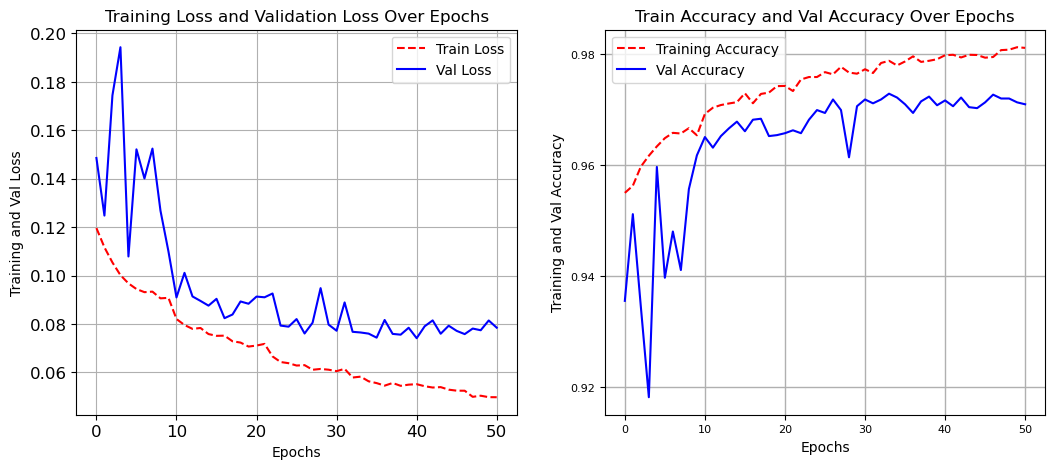

<Figure size 640x480 with 0 Axes>

In [40]:
G9_functions.plot_learning_curves({'best_model':history_best_model})
plt.savefig("Learning_curves_Best_Conformer_Model.png")

The conformer model shows a slight improvement over the transformer model. The model does appear to be overfitting with the addition of the convolutional blocks. This is only small though.

In [41]:
model_file_path = "Snoring_Binary_Conformer_Model" #model file path
best_conformer_model.save(model_file_path,save_format="tf")

INFO:tensorflow:Assets written to: Snoring_Binary_Conformer_Model\assets


INFO:tensorflow:Assets written to: Snoring_Binary_Conformer_Model\assets


### Choosing a threshold

In this section we want to determine if a threshold of 0.5 is adequate. To do this the precision and recall curves will be examined for the validation dataset.

In [43]:
y_proba_val = best_conformer_model.predict(X_val_100[:,:,:-1])

180/180 [==============================] - 4s 20ms/step


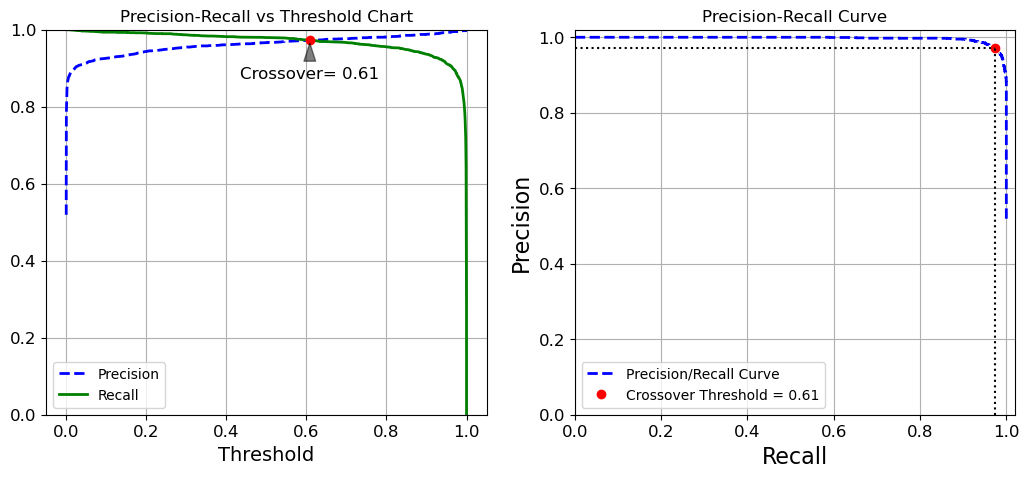

In [44]:
G9_functions.precision_recall_threshold_charts(y_val_100_B,y_proba_val,crossover=True)

The precision-recall curves for the validation dataset crossover when the threshold is equal to 0.61. The aim is to limit false positives or increase precision so having a slightly higher threshold may prove more valuable. Using a threshold of 0.6 might be better suited.

# Performance Metrics

In [45]:
y_proba_test = best_conformer_model.predict(X_test_100[:,:,:-1])
threshold=0.61
y_pred_test =(y_proba_test >= threshold).astype(int)

240/240 [==============================] - 5s 21ms/step


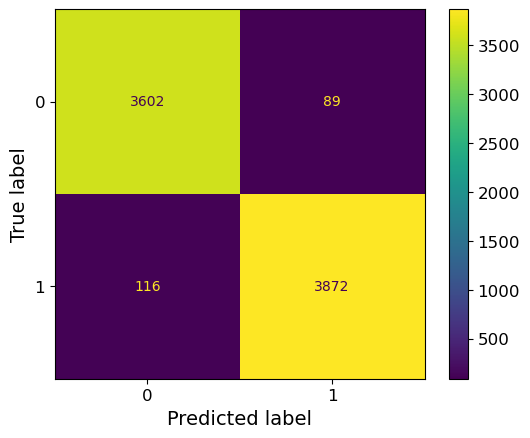

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report, precision_recall_curve, confusion_matrix,precision_score, recall_score
cm_fig=ConfusionMatrixDisplay(confusion_matrix(y_test_100_B,y_pred_test))
cm_fig.plot()

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test_100_B,y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3691
           1       0.98      0.97      0.97      3988

    accuracy                           0.97      7679
   macro avg       0.97      0.97      0.97      7679
weighted avg       0.97      0.97      0.97      7679



The CM and classification report show that the model has an accuracy of **96%** on the test dataset and a precsion of **97%**. These results are highly promising.

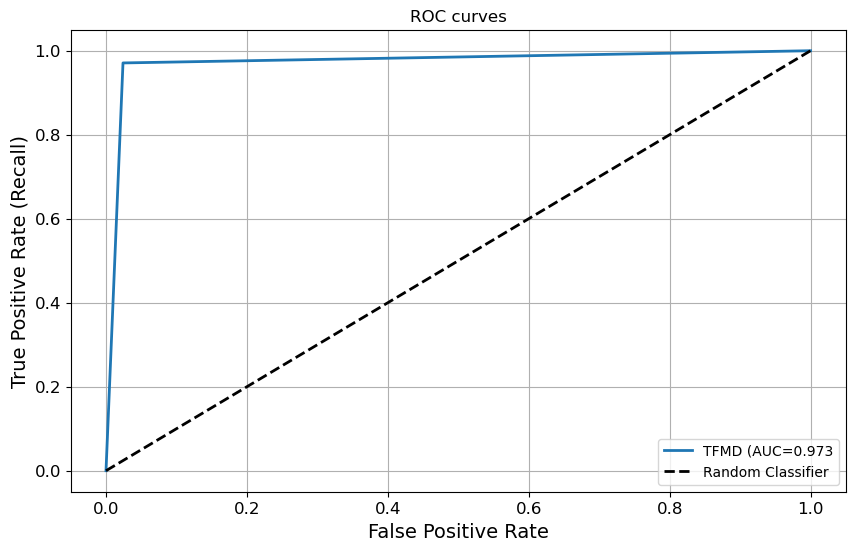

In [50]:
G9_functions.plot_roc_curves(y_test_100_B, {'TFMD':y_pred_test})